# Example 2: Comparing the $\texttt{fitrd}$ algorithm with a least squares approach

This example provided here compares the measured QNMs from two approached: (1) the algorithm in $\texttt{fitrd}$ and (2) a least squares approach.

In particular, we reproduce the example from Appendix A of Lim and Hughes (2022). 

When the ringdown waveforms contain unmodeled behavior such as numerical errors, the fitted mode amplitudes do not stabilize over time. In this case, we can associate the mode amplitude with the hyperparameter average over a range of fit times.

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import qnm
import fitrd.fitrd as fitrd

from scipy.optimize import minimize

## [1] Load waveform data

First, let's load the waveform data we'll use to extract the QNM amplitudes. We also need to get the fiducial time which is needed to define a ringdown model

### [1.1] Calculate fiducial time using trajectory data
Calculate lightring crossing time as in Eq. (7) in Lim and Hughes (2022)

In [24]:
spin = 0.1
traj_data = pd.read_csv("./sample_data/a0.1_thi025_thf087.8_n.traj",engine='python',delim_whitespace=True,usecols=[0,1], names=['t','r'],skiprows=240000)
lr_radius = 2*(1+np.cos((2./3.)*np.arccos(-np.abs(spin))))
t_fiducial = np.interp(lr_radius, traj_data['r'].loc[::-1],traj_data['t'].loc[::-1])

### [1.2] Load waveforms
The waveform file `hm0_a0.1_thi025_thf087.8_n.dat` contains the columns: `time, h00+, h00x, h10+, h10x, h20+, h20x, h30+, h30x, h40+, h40x, h50+,  h50x, h60+, h60x`

For this analysis, we will only use the columns: `time, h20+, h20x, h30+, h30x, h40+, h40x`

In [25]:
column_names = ['t','h20p','h20c','h30p','h30c','h40p','h40c']
wave_data = pd.read_csv("./sample_data/hm0_a0.1_thi025_thf087.8_n.dat",engine='python',delim_whitespace=True,usecols=[0,5,6,7,8,9,10], names=column_names)
for l in [2,3,4]:
    wave_data[f'h{l}0'] = wave_data[f'h{l}0p'] - 1j * wave_data[f'h{l}0c']

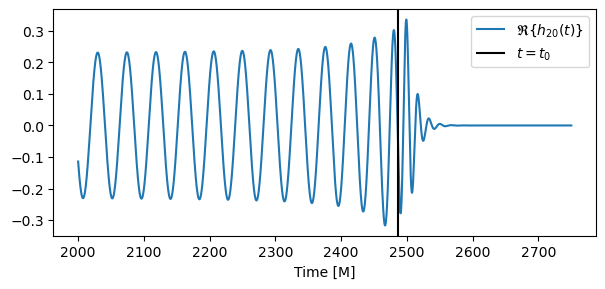

In [26]:
plt.figure(figsize=(7,3),dpi=100)
plt.plot(wave_data['t'],wave_data['h20p'], label=r'$\mathfrak{R} \lbrace h_{2 0}(t)\rbrace $')
plt.axvline(t_fiducial, color='k', label=r'$t = t_0$')
plt.xlabel('Time [M]')
plt.legend();

## [2] Calculate QNM amplitudes with least squares approach

Now that we've loaded the waveform, let's define a least squares algorithm to fit the waveform. 

A spherical harmonic mode $h_{\ell m}$ can be modeled as a linear sum of quasi-normal modes with amplitudes $C_{\ell' m}$ and $C'_{\ell' m}$:

$h_{\ell m} = \sum_{\ell'} \gamma_{ \ell' m}(t)\ C_{\ell' m} + \gamma_{ \ell' -m}(t)\ C_{\ell' -m} $

We assume that the spin is known beforehand (in this example, we fix $a/M = 0.1$ throughout). The second term is from the contribution of the mirror modes. See Eq. (3.10) in Lim, Khanna, Apte, Hughes (2019) for the definition of $\gamma$ and $\gamma'$s

### [2.1] Define a model function of the QNM amplitudes

We implement this model by building a building a function $h_{\ell m}(t) = f(\vec{C};t)$ that models the spherical mode $h_{\ell m}$ given an array of complex-valued QNM amplitudes $\vec{C}$

To build such a function we need to specify:
- `qnm_labels` List of QNM mode labels to include in the model, each labeled as `[ell_prime, m, is_mirror]`, where `is_mirror = 1` if mirror mode and `is_mirror = 0`  if non-mirror mode
- `l,m` Spherical harmonic indices
- `times` List of times to compute the spherical harmonic mode

In [27]:
def gamma(qnm_label,l,m,times):
    """
    inputs:
    - qnm_label: list of integers labeling a unique fundamental QNM, [ell_prime, m, is_mirror]
    - l, m: spherical harmonic indices labeling the data that we are fitting
    - times: range of times to compute output
    
    output:
    - linear coefficient of the specified QNM (see markdown text above this notebook cell)    
    """
    ell_prime, m, mirror_mode = qnm_label
    
    if mirror_mode == 0:
        overlap = fitrd.mulmlpnp(m,l,ell_prime,0,spin)
        omega_j = -1j * qnm.modes_cache(-2,ell_prime,m,0)(spin)[0]
        return overlap * np.exp(omega_j * times)
    
    elif mirror_mode == 1:
        overlap = fitrd.mulmlpnp(-m,l,ell_prime,0,spin)
        omega_j = 1j * np.conjugate(qnm.modes_cache(-2,ell_prime,-m,0)(spin)[0])
        return overlap * np.exp(omega_j * times)    


def build_hlm_model(qnm_labels,l,m,times):
    """
    inputs:
    - qnm_labels: list of list of integers. Each element labels a unique fundamental QNM, [[ell_prime, m, is_mirror],...]
    - l, m: spherical harmonic indices labeling the data that we are fitting
    - times: range of times to calculate hlm
    
    output:
    - hlm: function that calculates the (complex-valued) spherical mode of index (l,m) using specified spheroidal modes
    
    """
    factors = [gamma(qnm_label,l,m,times) for qnm_label in qnm_labels]
    def hlm(clm_array):
        """ Function returning spherical mode hlm over time given list of complex-valued QNM amplitudes """
        return np.dot(clm_array,factors)        
    return hlm

### [2.2] Define least squares method
We can now find then best fit QNM amplitudes with `scipy.optimize.minimize`
- [To use `scipy.optimize.minimize`](https://stackoverflow.com/questions/51211055/can-scipy-optimize-minimize-functions-of-complex-variables-at-all-and-how), we need to re-express our search parameters as an array over floats rather than complex values 

In [28]:
def real_to_complex(z):
    """ real vector of length 2n -> complex of length n"""
    return z[:len(z)//2] + 1j * z[len(z)//2:]

def complex_to_real(z):
    """ complex vector of length n -> real of length 2n"""
    return np.concatenate((np.real(z), np.imag(z)))


def fit_qnm_amplitudes(qnm_labels,l,m,times,hlm_data):
    """
    Function returning best best complex-valued QNM amplitudes
        
    inputs:
    - qnm_labels: list of list of integers. Each element labels a unique fundamental QNM, [[ell_prime, m, is_mirror],...]
    - l, m: spherical harmonic indices labeling the data that we are fitting
    - times: range of times to calculate hlm
    - hlm_data: spherical harmonic mode data
    
    output:
    - list of best fit complex-valued QNM amplitudes
    """    
    hlm_model = build_hlm_model(qnm_labels,l,m,times)
    fun = lambda x: np.linalg.norm(hlm_data - hlm_model(x))
    res = minimize(lambda x: fun(real_to_complex(x)), x0=complex_to_real(np.ones(len(qnm_labels))))
    return hlm_model,real_to_complex(res.x)

### [2.3] Execute least squares
Perform a series of least squares fit of $h_{20}$ to fine the best fit QNM amplitudes
- Fit a 1-pair mode model, with QNM pairs $\ell = 2$
- Fit a 3-pair mode model, with QNM pairs $\ell = 2,3,4$


In [29]:
 # Spherical harmonic mode to fit
(l,m) = (2,0)

# Labels of QNMs to include in model, for N = 1 and N = 3 QNM-pairs
model_qnm_labels = {1: [[2,0,0],[2,0,1]],
                    3: [[2,0,0],[2,0,1],[3,0,0],[3,0,1],[4,0,0],[4,0,1]]}

To estimate the quality of the fit, compute the mismatch $\mathcal{M} =  1 - |\langle h_{\ell m}^{\rm data}, h_{\ell m}^{\rm model} \rangle\  /\  \langle h_{\ell m}^{\rm data}, h_{\ell m}^{\rm data} \rangle|$, where $\langle x, y \rangle = \sum x(t_i) y(t_i)^*$

In [30]:
def mismatch(y1,y2):
    norm1 = np.dot(y1,np.conjugate(y1)).real
    norm2 = np.dot(y2,np.conjugate(y2)).real
    return 1 - np.abs(np.dot(y1,np.conjugate(y2))) / np.sqrt(norm1*norm2)

Compute fits for 1-pair and 3-pair models at successive fitting windows $ \lbrace \lbrack 0\ M, 150\ M \rbrack, ...,\lbrack t_{\rm start}, 150\ M \rbrack, ... \rbrace$, where $0 \leq t_{\rm start} \leq 100\ M$

In [31]:
t_starts = np.arange(0,100,.1) # series of fitting windows labeled by start time
N_windows = len(t_starts)

clm_fits_ls = {N_pairs: np.zeros((N_windows,2*N_pairs),dtype=complex) for N_pairs in model_qnm_labels.keys()} # amplitudes
mismatch_fits = {N_pairs: np.zeros(N_windows) for N_pairs in model_qnm_labels.keys()} # mismatches

for i, t_start in enumerate(tqdm.tqdm(t_starts)):
    
    mask = (wave_data['t'] - t_fiducial >= t_start) & (wave_data['t'] - t_fiducial <= 150)
    times = wave_data['t'].loc[mask] - t_fiducial
    hlm_data = wave_data['h20'].loc[mask]    
    
    for N_pairs, qnm_labels in model_qnm_labels.items():    
        hlm_model, clm_fits_ls[N_pairs][i] = fit_qnm_amplitudes(qnm_labels,l,m,times,hlm_data)
        mismatch_fits[N_pairs][i] = mismatch(hlm_data,hlm_model(clm_fits_ls[N_pairs][i]))

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:15<00:00,  2.30it/s]


## [3] Calculate QNM amplitudes with $\texttt{fitrd}$
### [3.1] Solve for spheroidal amplitudes over time 

Perform mode extraction for a set of spherical modes of index $m$: $\lbrace {h}{_{\ell m}^{\rm N}}(t) \rbrace \rightarrow  \lbrace \mathcal{A}_{kmn},\varphi_{k m n},\mathcal{A}'_{k -m n}, \varphi'_{k -m n} \rbrace$

- Include spheroidal-spherical mode mixing in the range $\ell_{\rm min} \leq \ell \leq |m| + K_{\ell}$ [c.f. Eq. (3.10) in Lim, Khanna, Apte, Hughes (2019)]
- $\texttt{preparesystem}$ pre-computes weights used in the algorithm. If this is the first time running, will store result as a numpy pickle and use for future calculations by default.
- List of extracted QNM modes are labeled by $(\ell, m, I_{\rm mirror})$, where $I_{\rm mirror} = 1$ if mirror mode and $I_{\rm mirror} =0$ if non-mirror mode

In [32]:
k_ell = 4
spherical_mode, time, spheroidal_coef = fitrd.solve_system(m, k_ell, t_fiducial,["./sample_data/hm0_a0.1_thi025_thf087.8_n.dat"],fitrd.preparesystem(m,spin,k_ell,cachedir='./precomputed_weights'))

### [3.2] Calculate average across fits
Averaging spheroidal amplitudes over fitting times

In [33]:
# Fit averaging hyperparameters
t_start = t_fiducial + 10
t_end = t_start + 220
t_window = 50

c_amps, c_phases = fitrd.postprocess(time,spheroidal_coef,t_start,t_end,t_window)

## [4] Plot Results

### [4.1] Plot fitted amplitudes vs. fitting window
Compare least squares vs. $\texttt{fitrd}$ results for $C_{200}$ QNM amplitude. We plot the average of the $\texttt{fitrd}$ result as the green dotted line

All results are in agreement with each other and exhibit oscillations in the fitted amplitudes over fitting times

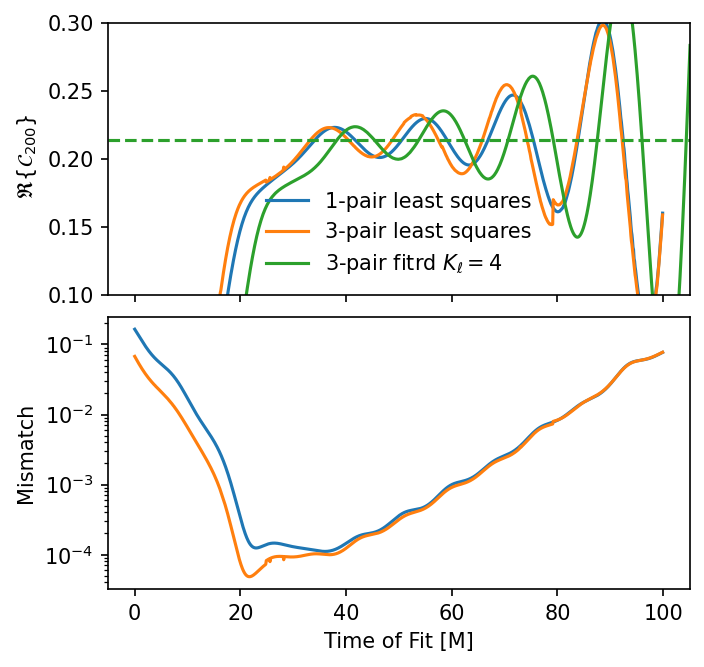

In [34]:
fig, ax = plt.subplots(2,1,figsize=(5,5),dpi=150,sharex=True)

plt.sca(ax[0])

plt.plot(t_starts,clm_fits_ls[1][:,0].real,label='1-pair least squares')
plt.plot(t_starts,clm_fits_ls[3][:,0].real,label='3-pair least squares')
plt.plot(time - t_fiducial,spheroidal_coef[:,0].real,label= '3-pair fitrd $K_{\ell} = 4$')
plt.axhline(c_amps[0] * np.cos(c_phases[0]),ls='--',color='C2')
ax[0].set_ylim(.1,.3)
plt.ylabel(r' $\mathfrak{R} \lbrace \mathcal{C}_{200} \rbrace$')
plt.legend(frameon=False)

plt.sca(ax[1])

plt.plot(t_starts,mismatch_fits[1])
plt.plot(t_starts,mismatch_fits[3])
plt.ylabel('Mismatch')
plt.yscale('log')

plt.xlim(-5,105)
plt.xticks(np.arange(0,120,20));
fig.subplots_adjust(hspace=.08);
plt.xlabel('Time of Fit [M]');

### [4.2] Plot the models with the best fit amplitudes

In [79]:
# Find the "best" lowest mismatch amplitudes for the 3-pair least squares fit
best_model = np.argmin(mismatch_fits[3])
best_t_start = t_starts[best_model]
clm_fits_ls_best = clm_fits_ls[3][best_model]

# Get the model function defined between [20,150M]
plot_range = (wave_data['t'] - t_fiducial >= 20) & (wave_data['t'] - t_fiducial <= 130)
times = wave_data['t'].loc[plot_range] - t_fiducial
hlm_data = wave_data['h20'].loc[plot_range]        
hlm_model, _ = fit_qnm_amplitudes(qnm_labels,l,m,times,hlm_data)

(80.0, 130.0)

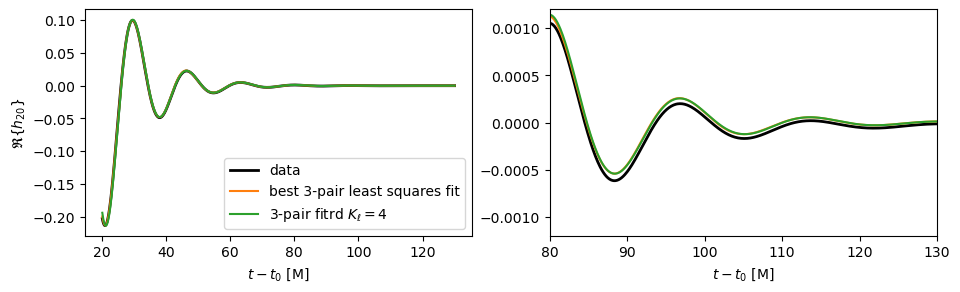

In [93]:
fig, ax = plt.subplots(1,2,figsize=(11,3),dpi=100)

for axi in ax:
    axi.plot(times,hlm_data.values.real,label='data',color='k',lw=2)
    axi.plot(times,hlm_model(clm_fits_ls_best).real,label='best fit 3-pair least squares',color='C1')
    axi.plot(times,hlm_model(c_amps * np.exp(1j*c_phases)).real,label=r'3-pair fitrd $K_{\ell} = 4$',color='C2')
    axi.set_xlabel('$t - t_0$ [M]')
    
plt.sca(ax[0])
plt.ylabel(r'$\mathfrak{R} \lbrace h_{20} \rbrace$')
plt.legend()

plt.sca(ax[1])
plt.ylim(-.0012,.0012)
plt.xlim(80,130)

### [4.3] Plot the residuals of the models

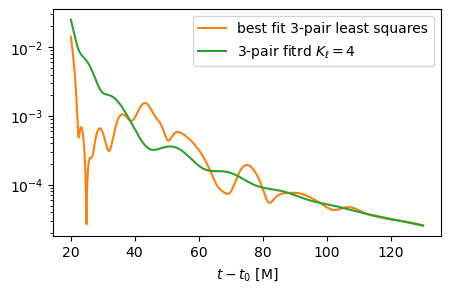

In [96]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=100)

ax.plot(times,np.abs(hlm_data.values - hlm_model(clm_fits_ls_best)),label='best fit 3-pair least squares',color='C1')
ax.plot(times,np.abs(hlm_data.values -hlm_model(c_amps * np.exp(1j*c_phases))),label=r'3-pair fitrd $K_{\ell} = 4$',color='C2')
ax.set_xlabel('$t - t_0$ [M]')
plt.yscale('log')
plt.legend();